In [1]:
from sklearn.neighbors import KernelDensity
import numpy as np
from matplotlib import pyplot as plt
import collections
import re
import pandas as pd
from functools import reduce

## Using Bag of Words

### The hard way!

In [33]:
doc1 = 'This is the way.'
doc2 = 'We need a buddy cop series of Mando and Grogu. We need it now.'
doc3 = 'How do I binge shows that are one week apart?'

formatted_docs = [ (re.sub(r"[^a-zA-Z0-9]", " ", x.lower()).split()) for x in [doc1, doc2, doc3]]
wordset = reduce(np.union1d, formatted_docs)


def calculateBOW(wordset,l_doc):
  tf_diz = dict.fromkeys(wordset,0)
  for word in l_doc:
      tf_diz[word]=l_doc.count(word)
  return tf_diz

bow_calcs = pd.DataFrame([calculateBOW(wordset, x) for x in formatted_docs])

In [5]:
bow_calcs

,a,and,apart,are,binge,buddy,cop,do,grogu,how,...,of,one,series,shows,that,the,this,way,we,week
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
1,1,1,0,0,0,1,1,0,1,0,...,1,0,1,0,0,0,0,0,2,0
2,0,0,1,1,1,0,0,1,0,1,...,0,1,0,1,1,0,0,0,0,1


In [213]:
wordset

array(['a', 'and', 'apart', 'are', 'binge', 'buddy', 'cop', 'do', 'grogu',
       'how', 'i', 'is', 'it', 'mando', 'need', 'now', 'of', 'one',
       'series', 'shows', 'that', 'the', 'this', 'way', 'we', 'week'],
      dtype='<U6')

In [214]:
bow_calcs

,a,and,apart,are,binge,buddy,cop,do,grogu,how,...,of,one,series,shows,that,the,this,way,we,week
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
1,1,1,0,0,0,1,1,0,1,0,...,1,0,1,0,0,0,0,0,2,0
2,0,0,1,1,1,0,0,1,0,1,...,0,1,0,1,1,0,0,0,0,1


### The easy way! 

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=u"(?u)\\b\\w+\\b") ## Why is this needed?
#print(vectorizer.get_feature_names())
X = vectorizer.fit_transform([doc1, doc2, doc3])
bow_df_short = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
bow_df_short

,a,and,apart,are,binge,buddy,cop,do,grogu,how,...,of,one,series,shows,that,the,this,way,we,week
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
1,1,1,0,0,0,1,1,0,1,0,...,1,0,1,0,0,0,0,0,2,0
2,0,0,1,1,1,0,0,1,0,1,...,0,1,0,1,1,0,0,0,0,1


### Getting rid of all stop words

In [8]:
vectorizer = CountVectorizer(stop_words='english', token_pattern=u"(?u)\\b\\w+\\b")
X = vectorizer.fit_transform([doc1, doc2, doc3])
bow_df_trimmed = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
bow_df_trimmed.head()

,apart,binge,buddy,cop,grogu,mando,need,series,shows,way,week
0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,1,1,1,2,1,0,0,0
2,1,1,0,0,0,0,0,0,1,0,1


## Normalization

In [217]:
bow_df_trimmed.sum(axis = 1)

0    1
1    7
2    4
dtype: int64

In [9]:
norm_factor_l1=np.linalg.norm(bow_df_trimmed.values,axis=1, ord = 1)
norm_factor_l2= np.linalg.norm(bow_df_trimmed.values,axis=1, ord = 2)

In [11]:
norm_factor_l2

array([1., 3., 2.])

In [13]:
normed_matrix = bow_df_trimmed.divide(norm_factor_l2, axis = "rows")
normed_matrix

,apart,binge,buddy,cop,grogu,mando,need,series,shows,way,week
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0
1,0.0,0.0,0.333333,0.333333,0.333333,0.333333,0.666667,0.333333,0.0,0.0,0.0
2,0.5,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,0.0,0.5


### An exploration of kernels

In [15]:
X = np.array([1,2,3,8,9,10]).reshape(-1, 1)
X

array([[ 1],
       [ 2],
       [ 3],
       [ 8],
       [ 9],
       [10]])

(array([1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 1.]),
 array([ 1.  ,  1.45,  1.9 ,  2.35,  2.8 ,  3.25,  3.7 ,  4.15,  4.6 ,
         5.05,  5.5 ,  5.95,  6.4 ,  6.85,  7.3 ,  7.75,  8.2 ,  8.65,
         9.1 ,  9.55, 10.  ]),
 <BarContainer object of 20 artists>)

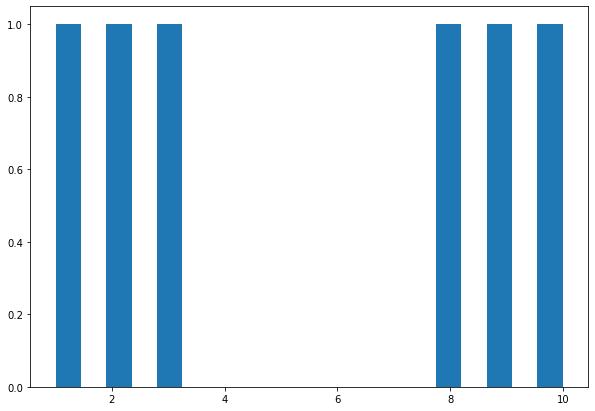

In [16]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(X, bins= 20)

In [17]:
kde05 = KernelDensity(kernel='tophat', bandwidth=.5).fit(X) #this is uniform kernel
kde1 = KernelDensity(kernel='tophat', bandwidth=1).fit(X) 
kde15 = KernelDensity(kernel='tophat', bandwidth=1.5).fit(X)

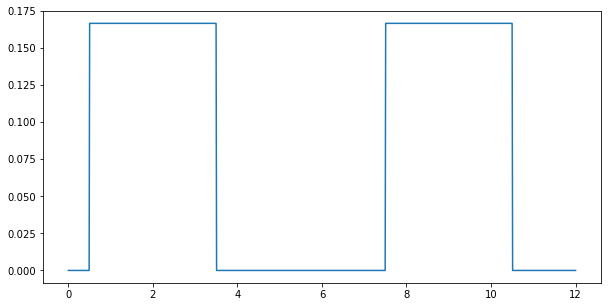

In [26]:
#np.exp(kde05.score_samples([[3]]))
#np.exp(kde15.score_samples([[3]]))
#np.exp(kde1.score_samples([[3]]))
X_plot = np.linspace(0, 12, 1000)[:, np.newaxis]

fig, ax = plt.subplots(figsize = (10,5))

ax.plot(
        X_plot[:, 0],
        np.exp(kde05.score_samples(X_plot)))


In [30]:
np.exp(kde1.score_samples([[2]]))

array([0.08333333])

In [28]:
# Now lets combine them.

Using: KernelDensity(bandwidth=0.5, kernel='tophat')
Using: KernelDensity(bandwidth=1, kernel='tophat')
Using: KernelDensity(bandwidth=1.5, kernel='tophat')
Using: KernelDensity(bandwidth=1)


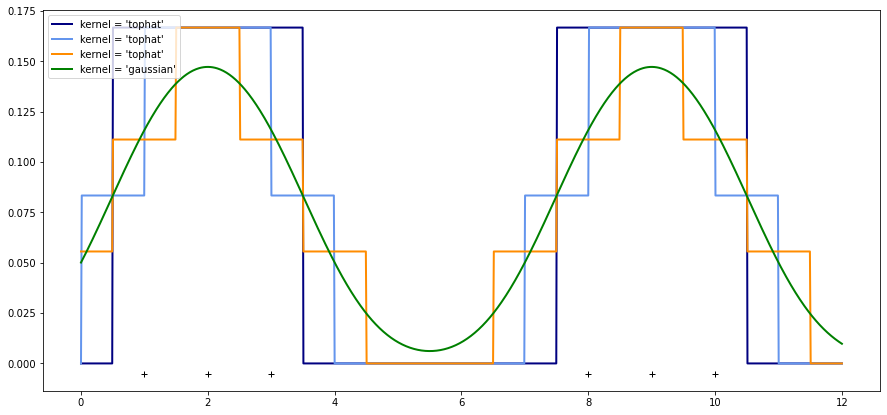

In [32]:
fig, ax = plt.subplots(figsize =(15, 7))
colors = ["navy", "cornflowerblue", "darkorange", "green"]
bandwidth = [0.5, 1, 1.5, 1]
kernel = ["tophat", "tophat", "tophat", "gaussian"]
kde_estimates = []
for color, bandwidth, kernel in zip(colors, bandwidth, kernel):
     kde_estimates.append(KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(X))
     print("Using: " + str(kde_estimates[-1]))
     ax.plot(
        X_plot[:, 0],
        np.exp(kde_estimates[-1].score_samples(X_plot)),
        color=color,
        lw=2,
        linestyle="-",
        label="kernel = '{0}'".format(kernel),
    )
        
ax.legend(loc="upper left")
ax.plot(X[:, 0], [-0.005]*6 , "+k")